# Simple DQN on Keras
The DQN Algorithm solves the issues related to the function approximations with Neural Networks:
* Bootstrap issue (Estimation with an estimation)
* Uncorrelate samples of experiences to facilitate Gradient Descent

### Loss Function
We can use as loss function the Mean Squared error between the model prediction of the Q value and a target calculated with the Bellman Equation
![alt text](imgs/loss_func_aprox.png "Game")

### Q Learning Update equation
The update equation will provides us the target for our loss function.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]$$
```python
Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
```

![alt text](imgs/DQN.png "DQN")

<img src="imgs/dqn_algo.png" alt="Algorithm DQN" style="width: 600px;"/>

### Act Greedy
$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$

### Target Error
$\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))$

### References
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time
* https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
* https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/keras-rl/keras-rl
* https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
* https://stackoverflow.com/questions/17280575/pdb-ipdb-for-python-break-on-editable-condition
* https://davidhamann.de/2017/04/22/debugging-jupyter-notebooks/
* https://colab.research.google.com/gist/Tony607/7f55518ba7af13eb7e2e782b3b50a38b/tensorboard_in_notebooks.ipynb
* https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/tensorboard/tf_dev_summit_2019.ipynb
* https://pytorch.org/docs/stable/notes/randomness.html

### Import Libraries

In [1]:
import gym
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import deque
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import datetime

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Compute device:', device)

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

## Plot function
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_durations(durations_t):
    plt.figure(2)
    plt.clf()    
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.plot(durations_t)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:        
        plt.plot(moving_average(durations_t,20))

Compute device: cpu


/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:564: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Define Hyperparameters

In [2]:
train_episodes = 600              # max number of episodes to learn from
gamma = 0.99                      # future reward discount

# Exploration parameters
explore_start = 1.0               # exploration probability at start (Pure exploratory)
explore_stop = 0.01               # minimum exploration probability
decay_rate = 0.0001               # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16                  # number of units in each Q-network hidden layer
learning_rate = 0.001             # Q-network learning rate

# Memory parameters
memory_size = 10000               # memory capacity
batch_size = 32                   # experience mini-batch size
pretrain_length = batch_size*10   # number experiences to pretrain the memory

consecutive_win_threshold = 5     # Number of Consecutive wins before stop training (5) (50 to the end)
target_updates = 5

/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Fix Random Seeds
To make the experiment reproducible, we will fix the following random seeds:
* OpenAI Gym
* Numpy
* Pytorch

In [3]:
env.seed(0)
np.random.seed(0)
torch.manual_seed(0)

/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Define Q-Network

In [4]:
class QNetwork(nn.Module):
    def __init__(self, env, state_size=4,
                 hidden_size=10):
        super(QNetwork, self).__init__()
        action_size = env.action_space.n
        
        self.d1 = nn.Linear(state_size, hidden_size)
        self.d2 = nn.Linear(hidden_size, hidden_size)
        self.d3 = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        return self.d3(x)
    
    def greedy_act(self, state):
        Q_values = self.forward(state)
        # Act greedly
        action = torch.argmax(Q_values)
        return action
    
    def set_weights(self, weights_dict):
         self.load_state_dict(weights_dict)
    
    def get_weights(self):
        return self.state_dict()
    

# Initialize DQN Network
mainQ = QNetwork(env, hidden_size=hidden_size)
targetQ = QNetwork(env, hidden_size=hidden_size)
targetQ.set_weights(mainQ.get_weights()) 

# Define loss and optimizer
loss_object = torch.nn.MSELoss()
optimizer = optim.Adam(mainQ.parameters(), lr=learning_rate)

### Define Training Graph

In [5]:
def train_step(inputs, targets, model):
    targets = torch.from_numpy(targets).float().to(device)
    predictions = model(inputs)
    # Calculate Loss
    loss = loss_object(targets, predictions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


### Memory Buffer

In [6]:
class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)
    
    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

memory = Memory(max_size=memory_size)

### Training

In [7]:
# Initialize the simulation
state = env.reset()
rewards_per_episode = []

step = 0
num_consecutive_win = 0

# For each episodes
for i_episode in range(1, train_episodes):
    total_reward = 0
    t = 0
    # Update the target network, copying all weights and biases in DQN
    if i_episode % target_updates == 0:
        targetQ.set_weights(mainQ.get_weights()) 
        
    done = False
    # Start new episode on the environment
    env.reset()      
    
    # Run an episode to the end
    while not done:
        step += 1
     
        # Epsilon Greedy Decay
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
        
        # Epsilon Greedy
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            action = mainQ.greedy_act(np.expand_dims(state, axis=0)).item()

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)        
        total_reward += reward

        # Episode finish
        if done:
            print('DONE! Episode: {}'.format(i_episode),
                  'Total reward: {}'.format(total_reward),
                  'Explore P: {:.4f}'.format(explore_p))
            
            rewards_per_episode.append(total_reward)

            # Early Stop
            if total_reward >= 199:
                num_consecutive_win += 1
                print('Win...')
            else:
                num_consecutive_win = 0                
            
            if num_consecutive_win > consecutive_win_threshold:                
                break

            # Add experience to memory
            memory.add((state, action, reward, next_state, done))      
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state, done))
            state = next_state

        # Check if we have enough samples on memory to sample
        # If we don't have keep gathering expriences
        if len(memory) >= batch_size:
            # Sample experience from Replay Memory
            minibatch = memory.sample(batch_size)
        else:
            # Keep populating replay memory
            print('Populating replay buffer')
            continue
        
        # Instantiate inputs (states) and targets         
        inputs = np.zeros((batch_size, np.prod(env.observation_space.shape)))
        targets = np.zeros((batch_size, env.action_space.n))
        
        
        # Iterate on the minibatch of samples from the replay memory
        for exp_idx, (state_b, action_b, reward_b, next_state_b, done_b) in enumerate(minibatch):
            #ipdb.set_trace()
            state_b = np.expand_dims(state_b, axis=0)
            next_state_b = np.expand_dims(next_state_b, axis=0)
            inputs[exp_idx] = state_b
            
            if done_b:
                # Mark target as immediate reward (If was last experience of some episode)
                target = reward_b
            else:
                # Calculate target as TD error
                target = reward_b + gamma * np.max(targetQ(next_state_b).detach().numpy())
            
            targets[exp_idx] = targetQ(state_b).detach().numpy()
            targets[exp_idx][action_b] = target
        
        # Update the model (In each episode end)
        train_step(inputs, targets, mainQ)
    
    # Stop Earlier ...
    if num_consecutive_win > consecutive_win_threshold:
        print('Number of consecutive wins high, stop earlier...')
        break

Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 1 Total reward: 23.0 Explore P: 0.9977
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 2 Total reward: 40.0 Explore P: 0.9938
DONE! Episode: 3 Total reward: 14.0 Explore P: 0.9924
DONE! Episode: 4 Total reward: 11.0 Explore P: 0.9913
DONE! Epi

### Plot Total Rewards per Episode

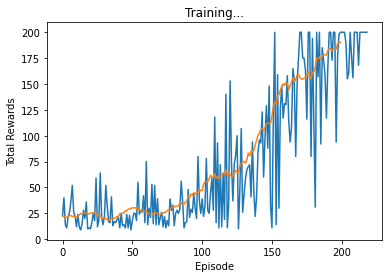

In [8]:
plot_durations(rewards_per_episode)

### Test trained Agent

In [13]:
def play_on_environment(env, model, t_max=4000, do_render=False):
    state = env.reset()
    for t in range(t_max):
        # Act greedly
        action = model.greedy_act(np.expand_dims(state, axis=0)).item()
        # Uncomment to render the visual state in a window
        if do_render:
            env.render()
        state, reward, done, _ = env.step(action)
        # Game finished
        if done:
            break
            
env = gym.wrappers.RecordVideo(gym.make("CartPole-v0"), 'video')
play_on_environment(env, mainQ, t_max=5000)
env.close()